In [1]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from plotly import tools
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Считаем данные из заранее подготовленных файлов.

In [2]:
mc = pd.HDFStore('mc.hdf5')['mc']

In [3]:
backtracks = pd.HDFStore('backtracks.hdf5')['backtracks']

In [4]:
backtracks['s.eZ'] = backtracks['p'] * 1293

Сделаем вспомогательную функцию для удобного представления ливня.

In [5]:
def get_mc_frame_sampled(data):
    ans = pd.DataFrame()
    ans['s.eX'] = data[2]
    ans['s.eY'] = data[3]
    ans['s.eZ'] = data[4]
    ans['s.eTX'] = data[5]
    ans['s.eTY'] = data[6]
    ans['s.eChi2'] = data[-1][np.where(data[-1] < 3)[0]]
    ans['signal'] = 1
    return ans

Напишем функцию для создания искусственного блока. Ввиду различий в координатах между шумом и ливнями, будем делать линейный сдвиг каждого ливня по отдельности с небольшим разбросом по координатам для равномерности распределения внутри шума.

In [6]:
def create_artificial_brick(mc, backtracks, showers, brick_size =  4 * 10 ** 3):
    backs = backtracks.sample(brick_size)
    backs['signal'] = 0
    del backs['p']
    max_brick = backs.quantile(0.75)[:3].values
    min_brick = backs.quantile(0.25)[:3].values
    delta_bricks = (max_brick - min_brick).min()
    mean_back = backs.mean()[:3].values
    
    mc_samples = mc.sample(showers)
    shower_list = []
    for i in range(showers):
        new_showers = get_mc_frame_sampled(mc_samples.values[i])
        max_showers = new_showers.max()[:3].values
        min_showers = new_showers.min()[:3].values
        delta_shower = (max_showers - min_showers).max()
        scale_shower = delta_bricks / delta_shower
        scale_shower *= np.random.uniform(0.8, 1.1)

        mean_shower = (new_showers * scale_shower).mean()[:3].values
        random_shift = [np.random.uniform(0.7, 1.3), np.random.uniform(0.2, 1.5), 1]
        shift_shower = (mean_back * np.array(random_shift)) - mean_shower
        
        new_values = (new_showers.values[:, :3] * scale_shower) + shift_shower
        for col, row in zip(['s.eX', 's.eY', 's.eZ'], range(3)):
            new_showers[col] = new_values[:, row]
        shower_list.append(new_showers)
        
    showers = pd.concat(shower_list, ignore_index=True)
    data = pd.concat((backs, showers), ignore_index=True)
    return data

Создадим блок.

In [7]:
sl = create_artificial_brick(mc, backtracks, 10)

In [8]:
sl_signal = sl[sl['signal'] == 1]
sl_back = sl[sl['signal'] == 0]

Визуализируем его в $3D$, а также всевозможных проекциях по каждой из координат, для этого воспользуемся библиотекой [Plotly](https://plot.ly/).

In [9]:
plotly.offline.init_notebook_mode(connected=True)

x, y, z = sl_signal['s.eX'], sl_signal['s.eY'], sl_signal['s.eZ']
trace11 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=6,
        line=dict(
            color='rgba(173,255,47, 1)',
            width=0.5
        ),
        opacity=0.9
    )
)

x2, y2, z2  = sl_back['s.eX'], sl_back['s.eY'], sl_back['s.eZ']
trace12 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=6,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.1
    )
)

trace21 = go.Scattergl(
    x=sl_signal['s.eX'],
    y=sl_signal['s.eZ'],
    mode='markers',
    marker=dict(
        size=6,
        line=dict(
            color='rgba(173,255,47, 1)',
            width=0.5
        ),
        opacity=0.9
    )
)

trace22 = go.Scattergl(
    x=sl_back['s.eX'],
    y=sl_back['s.eZ'],
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=6,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.1
    )
)

trace31 = go.Scattergl(
    x=sl_signal['s.eY'],
    y=sl_signal['s.eZ'],
    mode='markers',
    marker=dict(
        size=6,
        line=dict(
            color='rgba(173,255,47, 1)',
            width=0.5
        ),
        opacity=0.9
    )
)

trace32 = go.Scattergl(
    x=sl_back['s.eY'],
    y=sl_back['s.eZ'],
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=6,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.1
    )
)

trace41 = go.Scattergl(
    x=sl_signal['s.eX'],
    y=sl_signal['s.eY'],
    mode='markers',
    marker=dict(
        size=6,
        line=dict(
            color='rgba(173,255,47, 1)',
            width=0.5
        ),
        opacity=0.9
    )

)

trace42 = go.Scattergl(
    x=sl_back['s.eX'],
    y=sl_back['s.eY'],
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=6,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.1
    )
)


fig = tools.make_subplots(rows=2, cols=2,
                          specs=[[{'is_3d': True}, {'is_3d': False}],
                                 [{'is_3d': False}, {'is_3d': False}]],
                          print_grid = False,
                          subplot_titles=('Y projection', 'X projection', 'Z projection'))

fig.append_trace(trace11, 1, 1)
fig.append_trace(trace12, 1, 1)

fig.append_trace(trace21, 1, 2)
fig.append_trace(trace22, 1, 2)

fig.append_trace(trace31, 2, 1)
fig.append_trace(trace32, 2, 1)

fig.append_trace(trace41, 2, 2)
fig.append_trace(trace42, 2, 2)


fig['layout'].update(height=900, width=900)
plotly.offline.iplot(fig, link_text="")

Отобразим в виде картинки для доступности просмотра через GitHub.

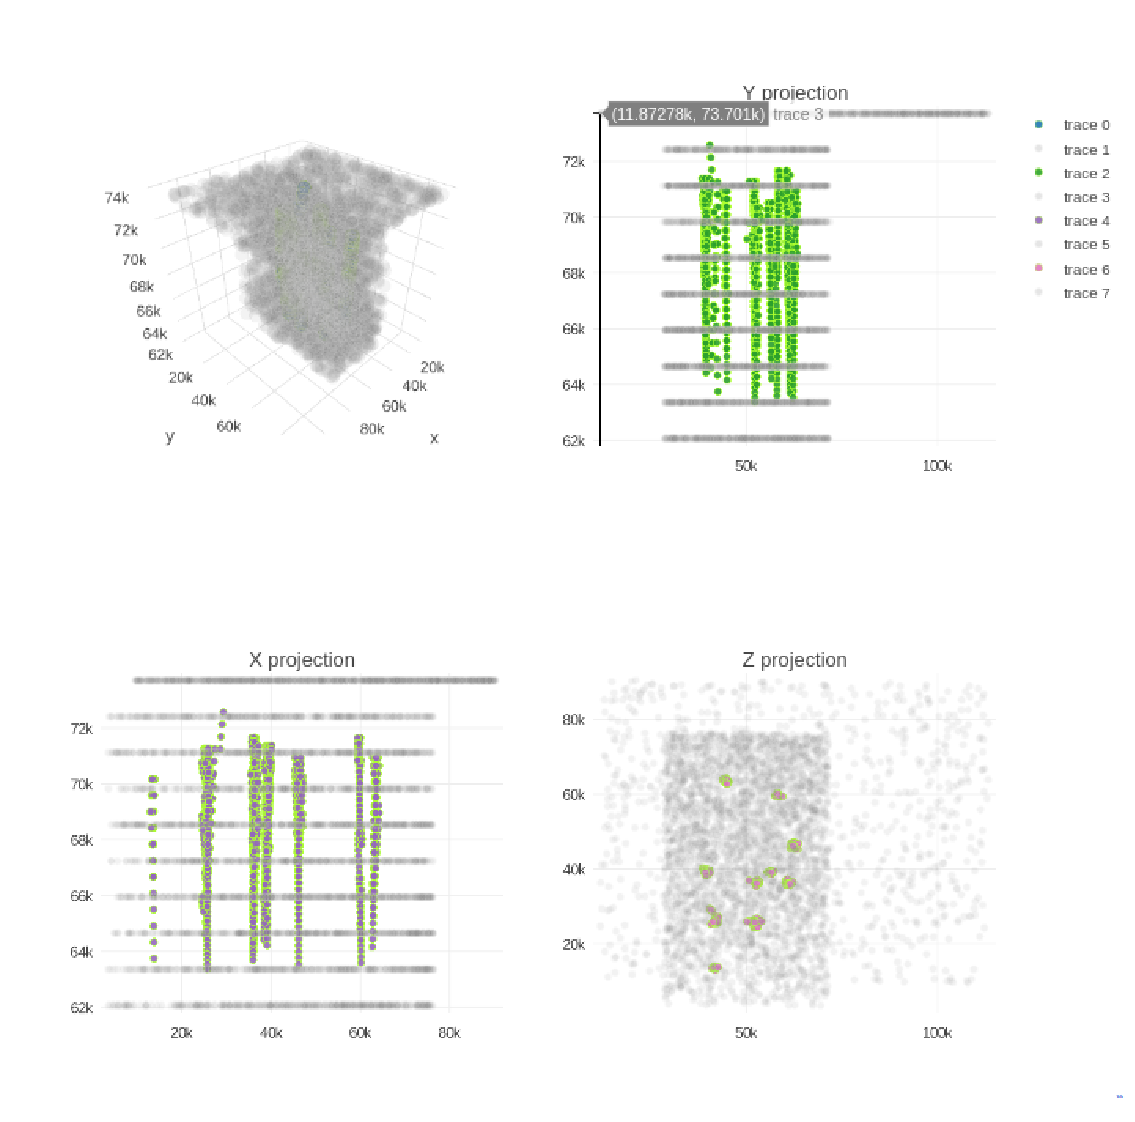

In [10]:
from skimage.io import imread
img = imread('screen.png')
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.show()